# <span style="color:#84b6f4;">Estudio comparativo de las posibles arquitecturas</span>

Se han planteado dos enfoques diferentes a la hora de abordar el modelo de IA. Las opciones son las siguientes:

Modelo 1-1: Cada modelo estará entrenado para detectar la presencia de un único actor.

Modelo 1-N: Cada modelo estará entrenado para detectar la presencia de N actores.

El objetivo del experimento es determinar qué enfoque es el más adecuado para abordar el problema. En el primer caso, se deberá entrenar el modelo N veces, una por cada actor. En el segundo, se deberá entrenar una sola vez, pero veremos si tiene una respuesta esperanzadora con una cantidad relativamente pequeña de imágenes de entrenamiento.

Realizaremos pruebas con Pedro Pascal, Bella Ramsey y Will Smith, con el objetivo de comprobar, con cada enfoque, los tiempos y para qué resultados, teniendo en cuenta que, si aumentamos el número de actores, la cantidad de imágenes necesarias para entrenar el modelo 1-N aumentará considerablemente.

### <span style="color:#77dd77;">Modelo 1-N</span>

Comenzaremos tratando de identificar a Pedro Pascal, Bella Ramsey y Will Smith utilizando el enfoque 1-N. Para ello, tendremos tres atributos; uno para cada actor, con el objetivo de etiquetar como 1 las imágenes en las que aparecen y como 0 las imágenes en las que no. Creamos el DataFrame:

In [1]:
import pandas as pd
import os
import random

# Directorios en los que se encuentran las imágenes
pedro_directory = os.getcwd() + '/resources/pedroPascalImages'
bella_directory = os.getcwd() + '/resources/bellaRamseyImages'
will_directory = os.getcwd() + '/resources/willSmithImages'
other_actors_directory = os.getcwd() + '/resources/otherActorsImages'

data = []

# Imágenes en las que aparece Pedro Pascal
for image in os.listdir(pedro_directory):
    image_url = os.path.join(pedro_directory, image)
    data.append({"image": image_url, "pedro_pascal": 1, "bella_ramsey": 0, "will_smith": 0})

# Imágenes en las que aparece Bella Ramsey
for image in os.listdir(bella_directory):
    image_url = os.path.join(bella_directory, image)
    data.append({"image": image_url, "pedro_pascal": 0, "bella_ramsey": 1, "will_smith": 0})

# Imágenes en las que aparece Will Smith
will_images = os.listdir(will_directory)[:150]
for image in will_images:
    image_url = os.path.join(will_directory, image)
    data.append({"image": image_url, "pedro_pascal": 0, "bella_ramsey": 0, "will_smith": 1})

# Imágenes en las que no aparece ninguno de los anteriores
other_actor_images = os.listdir(other_actors_directory)[:150]
for image in other_actor_images:
    image_url = os.path.join(other_actors_directory, image)
    data.append({"image": image_url, "pedro_pascal": 0, "bella_ramsey": 0, "will_smith": 0})

# Desordenamos aleatoriamente los datos
random.shuffle(data)

# Creamos el DataFrame
df = pd.DataFrame(data)

Mostramos las 10 primeras imágenes, en escala de grises y tras haber sido preprocesadas:

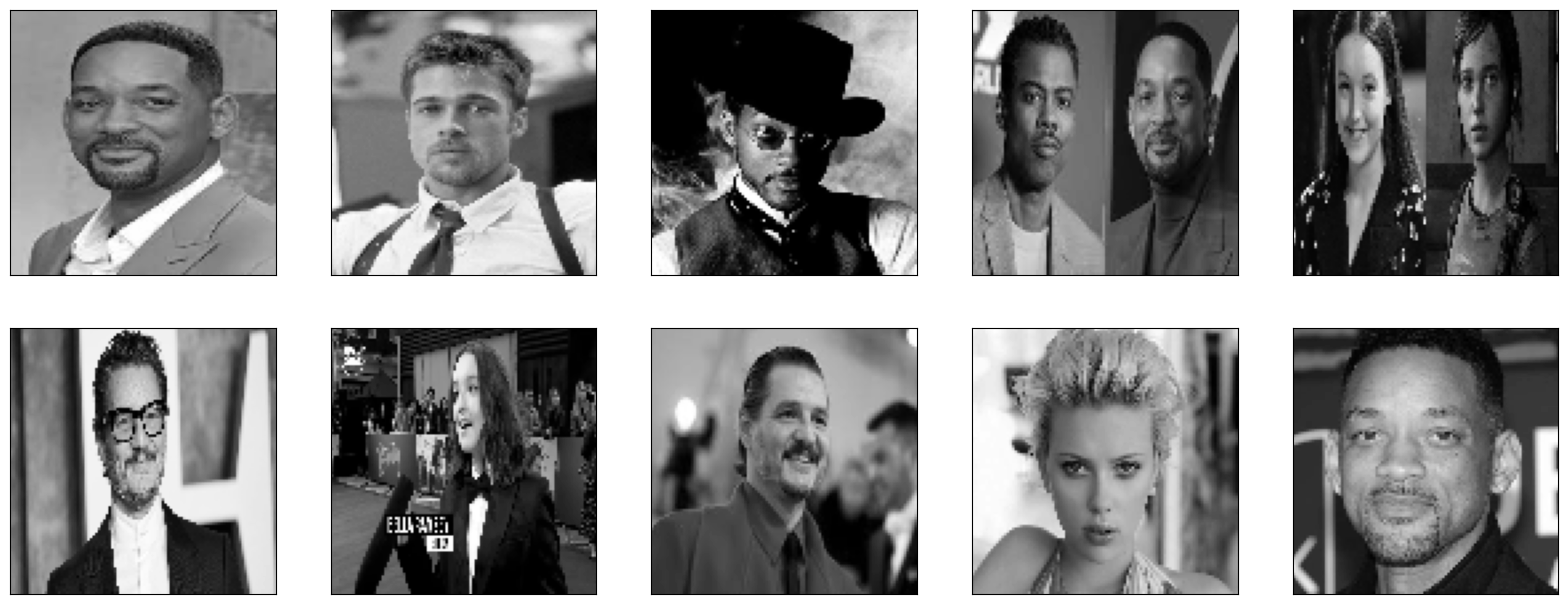

In [2]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20, 20))

IMG_SIZE = 100

def load_and_preprocess_image(url):
    """Recibe la url de una imagen y la preprocesa"""
    image = cv2.imread(url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

# Mostramos las 10 primeras imágenes
for i, row in df.head(10).iterrows():
    image_url = row['image']
    image = load_and_preprocess_image(image_url)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap='gray')

Cargamos las imágenes de entrada (los píxeles) y las etiquetas asociadas a cada imagen:

In [3]:
import numpy as np

images = []
labels = []

# Cargamos las imágenes y etiquetas asociadas del DataFrame en "images" y "labels"
for i, row in df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    images.append(image)
    labels.append([row['pedro_pascal'], row['bella_ramsey'], row["will_smith"]])

images = np.array(images).astype(float) / 255
labels = np.array(labels)

Aplicamos transformaciones de aumento de datos a las imágenes, para volver el conjunto de datos más diverso:

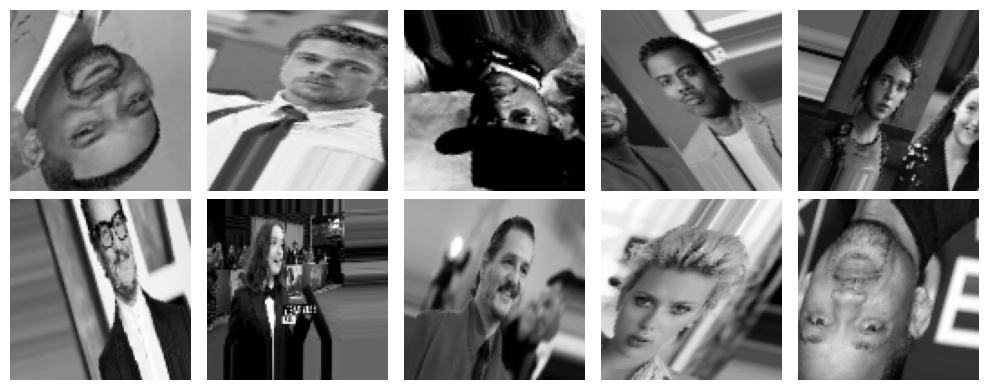

In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Creamos un generador de imágenes aumentadas
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajustamos el generador al conjunto de imágenes original
datagen.fit(images)

# Mostramos un lote de imágenes aumentadas
X_batch, y_batch = next(datagen.flow(images, labels, batch_size=10, shuffle=False))

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_batch[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos:

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)

# Creamos el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

# Configuramos el modelo para el entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=60,
    validation_data=(test_images, test_labels),
    steps_per_epoch=len(train_images) / 32,
    validation_steps=len(test_images) / 32
)

Epoch 1/60
13/13 [==============================] - 4s 228ms/step - loss: 0.5864 - accuracy: 0.4101 - val_loss: 0.5866 - val_accuracy: 0.4500
Epoch 2/60
13/13 [==============================] - 3s 228ms/step - loss: 0.5658 - accuracy: 0.4197 - val_loss: 0.5866 - val_accuracy: 0.4556
Epoch 3/60
13/13 [==============================] - 3s 215ms/step - loss: 0.5501 - accuracy: 0.4628 - val_loss: 0.5794 - val_accuracy: 0.2556
Epoch 4/60
13/13 [==============================] - 3s 211ms/step - loss: 0.5555 - accuracy: 0.3285 - val_loss: 0.5829 - val_accuracy: 0.4611
Epoch 5/60
13/13 [==============================] - 3s 213ms/step - loss: 0.5567 - accuracy: 0.4676 - val_loss: 0.5686 - val_accuracy: 0.4611
Epoch 6/60
13/13 [==============================] - 3s 226ms/step - loss: 0.5588 - accuracy: 0.5252 - val_loss: 0.5738 - val_accuracy: 0.4722
Epoch 7/60
13/13 [==============================] - 3s 217ms/step - loss: 0.5482 - accuracy: 0.4556 - val_loss: 0.5658 - val_accuracy: 0.4722
Epoch 

Realizamos las predicciones con los datos de prueba:

In [6]:
test_predictions = model.predict(test_images)

# Redondeamos las predicciones para obtener las clases predichas
test_predictions_rounded = (test_predictions > 0.5).astype(int)

# Obtenemos las predicciones separadas para cada actor
test_predictions_pedro = test_predictions_rounded[:, 0]
test_predictions_bella = test_predictions_rounded[:, 1]
test_predictions_will = test_predictions_rounded[:, 2]

6/6 [==============================] - 0s 32ms/step


Para finalizar, evaluamos los resultados del modelo; para ello, utilizaremos métricas como la precisión, el F1-score y la matriz de confusión:

In [7]:
# Evaluamos el modelo
pedro_accuracy = accuracy_score(test_labels[:, 0], test_predictions_pedro)
pedro_f1 = f1_score(test_labels[:, 0], test_predictions_pedro)
pedro_confusion = confusion_matrix(test_labels[:, 0], test_predictions_pedro)

bella_accuracy = accuracy_score(test_labels[:, 1], test_predictions_bella)
bella_f1 = f1_score(test_labels[:, 1], test_predictions_bella)
bella_confusion = confusion_matrix(test_labels[:, 1], test_predictions_bella)

will_accuracy = accuracy_score(test_labels[:, 1], test_predictions_will)
will_f1 = f1_score(test_labels[:, 1], test_predictions_will)
will_confusion = confusion_matrix(test_labels[:, 1], test_predictions_will)

# Mostramos los resultados
print("Resultados para Pedro:")
print("Precisión:", pedro_accuracy)
print("F1 Score:", pedro_f1)
print("Matriz de confusión:")
print(pedro_confusion)

print("Resultados para Bella:")
print("Precisión:", bella_accuracy)
print("F1 Score:", bella_f1)
print("Matriz de confusión:")
print(bella_confusion)

print("Resultados para Will:")
print("Precisión:", will_accuracy)
print("F1 Score:", will_f1)
print("Matriz de confusión:")
print(will_confusion)

Resultados para Pedro:
Precisión: 0.7666666666666667
F1 Score: 0.08695652173913043
Matriz de confusión:
[[136   1]
 [ 41   2]]
Resultados para Bella:
Precisión: 0.7111111111111111
F1 Score: 0.2571428571428571
Matriz de confusión:
[[119   8]
 [ 44   9]]
Resultados para Will:
Precisión: 0.6722222222222223
F1 Score: 0.09230769230769231
Matriz de confusión:
[[118   9]
 [ 50   3]]


Podemos comprobar que los resultados no son nada buenos. La precisión es relativamente alta, pero el modelo no generaliza bien. Al estar todas las clases subrepresentadas, lo más común es que, si se predice que en el ejemplo no aparece un determinado actor, se acierte. Eso hace que el modelo prediga casi siempre que el actor no aparece en la imagen, por lo que la precisión es alta pero el F1-Score significativamente bajo.

### <span style="color:#77dd77;">Modelo 1-1</span>

Ahora trataremos de identificar a los actores por medio del enfoque 1-1. Para ello, crearemos un modelo que detecte la presencia de un único actor y lo entrenaremos con las imágenes de Pedro Pascal, Bella Ramsey y Will Smith. Creamos los DataFrames:

In [8]:
pedro_data = []
bella_data = []
will_data = []

# Añadimos imágenes en las que aparece Pedro Pascal (e imágenes en las que no)
for image in os.listdir(pedro_directory):
    image_url = os.path.join(pedro_directory, image)
    pedro_data.append({"image": image_url, "pedro_pascal": 1})

for image in other_actor_images:
    image_url = os.path.join(other_actors_directory, image)
    pedro_data.append({"image": image_url, "pedro_pascal": 0})

# Añadimos imágenes en las que aparece Bella Ramsey (e imágenes en las que no)
for image in os.listdir(bella_directory):
    image_url = os.path.join(bella_directory, image)
    bella_data.append({"image": image_url, "bella_ramsey": 1})

for image in other_actor_images:
    image_url = os.path.join(other_actors_directory, image)
    bella_data.append({"image": image_url, "bella_ramsey": 0})

# Añadimos imágenes en las que aparece Will Smith (e imágenes en las que no)
for image in will_images:
    image_url = os.path.join(will_directory, image)
    will_data.append({"image": image_url, "will_smith": 1})

for image in other_actor_images:
    image_url = os.path.join(other_actors_directory, image)
    will_data.append({"image": image_url, "will_smith": 0})

# Desordenamos aleatoriamente los datos
random.shuffle(pedro_data)
random.shuffle(bella_data)
random.shuffle(will_data)

# Creamos los DataFrames
pedro_df = pd.DataFrame(pedro_data)
bella_df = pd.DataFrame(bella_data)
will_df = pd.DataFrame(will_data)

Cargamos las imágenes de entrada (los píxeles) y las etiquetas asociadas a cada imagen:

In [9]:
pedro_images = []; pedro_labels = []
bella_images = []; bella_labels = []
will_images = []; will_labels = []

# Cargamos las imágenes del DataFrame de Pedro Pascal
for i, row in pedro_df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    pedro_images.append(image)
    pedro_labels.append(row['pedro_pascal'])

# Cargamos las imágenes del DataFrame de Bella Ramsey
for i, row in bella_df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    bella_images.append(image)
    bella_labels.append(row['bella_ramsey'])

# Cargamos las imágenes del DataFrame de Will Smith
for i, row in will_df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    will_images.append(image)
    will_labels.append(row['will_smith'])

pedro_images = np.array(pedro_images).astype(float)/255; pedro_labels = np.array(pedro_labels)
bella_images = np.array(bella_images).astype(float)/255; bella_labels = np.array(bella_labels)
will_images = np.array(will_images).astype(float)/255; will_labels = np.array(will_labels)

Aplicamos transformaciones de aumento de datos a las imágenes, para volver el conjunto de datos más diverso:

In [10]:
datagen.fit(pedro_images)
datagen.fit(bella_images)
datagen.fit(will_images)

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos con las imágenes del DataFrame de Pedro Pascal:

In [11]:
# Dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%)
pedro_train_images, pedro_test_images, pedro_train_labels, pedro_test_labels = train_test_split(pedro_images, pedro_labels, test_size=0.3, random_state=42)
bella_train_images, bella_test_images, bella_train_labels, bella_test_labels = train_test_split(bella_images, bella_labels, test_size=0.3, random_state=42)
will_train_images, will_test_images, will_train_labels, will_test_labels = train_test_split(will_images, will_labels, test_size=0.3, random_state=42)

# Creamos el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuramos el modelo para el entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(
    datagen.flow(pedro_train_images, pedro_train_labels, batch_size=32),
    epochs=60, batch_size=32,
    validation_data=(pedro_test_images, pedro_test_labels),
    steps_per_epoch=int(np.ceil(len(pedro_train_images) / float(32))),
    validation_steps=int(np.ceil(len(pedro_test_images) / float(32)))
)

Epoch 1/60
7/7 [==============================] - 2s 199ms/step - loss: 0.6951 - accuracy: 0.5700 - val_loss: 0.6900 - val_accuracy: 0.5333
Epoch 2/60
7/7 [==============================] - 1s 182ms/step - loss: 0.7037 - accuracy: 0.4493 - val_loss: 0.6914 - val_accuracy: 0.5222
Epoch 3/60
7/7 [==============================] - 1s 180ms/step - loss: 0.6921 - accuracy: 0.5459 - val_loss: 0.6873 - val_accuracy: 0.5667
Epoch 4/60
7/7 [==============================] - 1s 181ms/step - loss: 0.6886 - accuracy: 0.5266 - val_loss: 0.6838 - val_accuracy: 0.5778
Epoch 5/60
7/7 [==============================] - 1s 185ms/step - loss: 0.6846 - accuracy: 0.5604 - val_loss: 0.6753 - val_accuracy: 0.5778
Epoch 6/60
7/7 [==============================] - 1s 180ms/step - loss: 0.6781 - accuracy: 0.5652 - val_loss: 0.6801 - val_accuracy: 0.5778
Epoch 7/60
7/7 [==============================] - 1s 180ms/step - loss: 0.6919 - accuracy: 0.5314 - val_loss: 0.6881 - val_accuracy: 0.5111
Epoch 8/60
7/7 [====

Evaluamos los resultados del modelo, utilizando métricas como la precisión, el F1-score y la matriz de confusión:

In [12]:
# Evaluamos el modelo
pedro_test_predictions = model.predict(pedro_test_images)
pedro_test_predictions_rounded = np.round(pedro_test_predictions)

pedro_accuracy = accuracy_score(pedro_test_labels, pedro_test_predictions_rounded)
pedro_f1 = f1_score(pedro_test_labels, pedro_test_predictions_rounded)
confusion_pedro = confusion_matrix(pedro_test_labels, pedro_test_predictions_rounded)

# Mostramos los resultados
print("Resultados para Pedro:")
print("Precisión:", pedro_accuracy)
print("F1 Score:", pedro_f1)
print("Matriz de confusión:")
print(confusion_pedro)

3/3 [==============================] - 0s 35ms/step
Resultados para Pedro:
Precisión: 0.6111111111111112
F1 Score: 0.5679012345679012
Matriz de confusión:
[[32 11]
 [24 23]]


Entrenamos el modelo con las imágenes del DataFrame de Bella Ramsey:

In [13]:
model.fit(
    datagen.flow(bella_train_images, bella_train_labels, batch_size=32),
    epochs=60, batch_size=32,
    validation_data=(bella_test_images, bella_test_labels),
    steps_per_epoch=int(np.ceil(len(bella_train_images) / float(32))),
    validation_steps=int(np.ceil(len(bella_test_images) / float(32)))
)

Epoch 1/60
7/7 [==============================] - 1s 195ms/step - loss: 0.6216 - accuracy: 0.6571 - val_loss: 0.6205 - val_accuracy: 0.6778
Epoch 2/60
7/7 [==============================] - 1s 189ms/step - loss: 0.6385 - accuracy: 0.6476 - val_loss: 0.6045 - val_accuracy: 0.6889
Epoch 3/60
7/7 [==============================] - 1s 202ms/step - loss: 0.5908 - accuracy: 0.6905 - val_loss: 0.5872 - val_accuracy: 0.6444
Epoch 4/60
7/7 [==============================] - 1s 189ms/step - loss: 0.5865 - accuracy: 0.6714 - val_loss: 0.5807 - val_accuracy: 0.6889
Epoch 5/60
7/7 [==============================] - 1s 193ms/step - loss: 0.6047 - accuracy: 0.6762 - val_loss: 0.5678 - val_accuracy: 0.7222
Epoch 6/60
7/7 [==============================] - 1s 191ms/step - loss: 0.5928 - accuracy: 0.7048 - val_loss: 0.5974 - val_accuracy: 0.6333
Epoch 7/60
7/7 [==============================] - 1s 194ms/step - loss: 0.5480 - accuracy: 0.7381 - val_loss: 0.5462 - val_accuracy: 0.7333
Epoch 8/60
7/7 [====

Evaluamos los resultados del modelo:

In [14]:
# Evaluamos el modelo
bella_test_predictions = model.predict(bella_test_images)
bella_test_predictions_rounded = np.round(bella_test_predictions)

bella_accuracy = accuracy_score(bella_test_labels, bella_test_predictions_rounded)
bella_f1 = f1_score(bella_test_labels, bella_test_predictions_rounded)
bella_confusion = confusion_matrix(bella_test_labels, bella_test_predictions_rounded)

# Mostramos los resultados
print("Resultados para Bella:")
print("Precisión:", bella_accuracy)
print("F1 Score:", bella_f1)
print("Matriz de confusión:")
print(bella_confusion)

3/3 [==============================] - 0s 37ms/step
Resultados para Bella:
Precisión: 0.8222222222222222
F1 Score: 0.8095238095238095
Matriz de confusión:
[[40  6]
 [10 34]]


Entrenamos el modelo con las imágenes del DataFrame de Will Smith:

In [15]:
model.fit(
    datagen.flow(will_train_images, will_train_labels, batch_size=32),
    epochs=60, batch_size=32,
    validation_data=(will_test_images, will_test_labels),
    steps_per_epoch=int(np.ceil(len(will_train_images) / float(32))),
    validation_steps=int(np.ceil(len(will_test_images) / float(32)))
)

Epoch 1/60
7/7 [==============================] - 1s 196ms/step - loss: 0.8120 - accuracy: 0.6190 - val_loss: 0.6686 - val_accuracy: 0.6000
Epoch 2/60
7/7 [==============================] - 1s 178ms/step - loss: 0.7389 - accuracy: 0.5667 - val_loss: 0.7115 - val_accuracy: 0.5222
Epoch 3/60
7/7 [==============================] - 1s 178ms/step - loss: 0.6549 - accuracy: 0.6238 - val_loss: 0.5571 - val_accuracy: 0.7222
Epoch 4/60
7/7 [==============================] - 1s 186ms/step - loss: 0.6447 - accuracy: 0.6048 - val_loss: 0.6035 - val_accuracy: 0.6444
Epoch 5/60
7/7 [==============================] - 1s 182ms/step - loss: 0.6761 - accuracy: 0.5714 - val_loss: 0.6720 - val_accuracy: 0.5333
Epoch 6/60
7/7 [==============================] - 1s 180ms/step - loss: 0.6460 - accuracy: 0.6667 - val_loss: 0.6144 - val_accuracy: 0.7111
Epoch 7/60
7/7 [==============================] - 1s 180ms/step - loss: 0.6394 - accuracy: 0.6381 - val_loss: 0.5910 - val_accuracy: 0.7000
Epoch 8/60
7/7 [====

Evaluamos los resultados del modelo:

In [16]:
# Evaluamos el modelo
will_test_predictions = model.predict(will_test_images)
will_test_predictions_rounded = np.round(will_test_predictions)

will_accuracy = accuracy_score(will_test_labels, will_test_predictions_rounded)
will_f1 = f1_score(will_test_labels, will_test_predictions_rounded)
will_confusion = confusion_matrix(will_test_labels, will_test_predictions_rounded)

# Mostramos los resultados
print("Resultados para Will:")
print("Precisión:", will_accuracy)
print("F1 Score:", will_f1)
print("Matriz de confusión:")
print(will_confusion)

3/3 [==============================] - 0s 31ms/step
Resultados para Will:
Precisión: 0.7111111111111111
F1 Score: 0.717391304347826
Matriz de confusión:
[[31  9]
 [17 33]]


### <span style="color:#77dd77;">Conclusiones</span>

Los resultados del enfoque 1-1, a pesar de haber utilizado la misma cantidad de imágenes de entrenamiento, son significativamente superiores. El modelo no acierta tanto pero generaliza bastante mejor, pudiendo mejorar la precisión con técnicas más sofisticadas, más y mejores imágenes y un mayor número de iteraciones.

Para entrenar el modelo 1-N se han utilizado 147 imágenes de Pedro Pascal, 150 de Bella Ramsey, 150 de Will Smith y 150 de otros actores (alrededor de 600 imágenes), exactamente igual que para entrenar el modelo 1-1, con la diferencia de que en cada entrenamiento se han utilizado 300 de ellas; 150 del actor del que se quería realizar la predicción y 150 de otros actores. En el enfoque 1-N, el entrenamiento se ha realizado con las 600 imágenes, quedando siempre las 150 de cada actor subrepresentadas.

Al querer predecir N actores con un solo modelo, siempre tendremos el problema del balanceo de clases, acentuándose éste cuanto mayor sea N. Esto hace que el modelo generalice realmente mal, y prediga casi siempre que el actor no aparece en la imagen, pues es lo más común. Los resultados mejorarían aplicando técnicas más sofisticadas pero, en cualquier caso, la cantidad de imágenes necesarias para que un modelo 1-N generalice bien no parece abordable en este contexto, puesto que 150 por actor han sido insuficientes con N=3, teniendo en cuenta que en cualquier obra N será significativamente mayor que 3.

Teniendo en cuenta los resultados, lo más razonable parece ser utilizar el enfoque 1-1. La principal desventaja es que el modelo deberá ser entrenado N veces y el número de llamadas será mayor, pero la cantidad de imágenes necesarias para obtener una precisión alta es significativamente menor. De hecho, el enfoque 1-N parece inabordable en este contexto, teniendo en cuenta que la cantidad de imágenes aumentará a mayor sea N, y N puede llegar a ser muy grande.